# 12-6. 프로젝트 - Movielens 영화 SBR

---

- `Movielens 1M Dataset`을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

## Step 0. 데이터 불러오기

In [200]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import matplotlib.pyplot as plt

In [201]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 
- 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.


- Rating 정보가 포함되어 있습니다. 
- 무시하고 제외할 수 있습니다만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 
- 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.


- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

## Step 1. 데이터의 전처리

In [202]:
# 유저수(세션 수)와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [203]:
# 유저별 리뷰 갯수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [204]:
# 리뷰 중앙값, 평균 리뷰 수
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [205]:
# 리뷰 최소값, 리뷰 최댓값
session_length.min(), session_length.max()

(20, 2314)

In [206]:
# 리뷰 분위수(전체 데이터의 0.999%)
session_length.quantile(0.999)

1343.181000000005

In [207]:
# 최다 리뷰자 확인해보기
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


**세션 길이 시각화**
- 세션 길이에 따른 분포 확인해보기

In [208]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

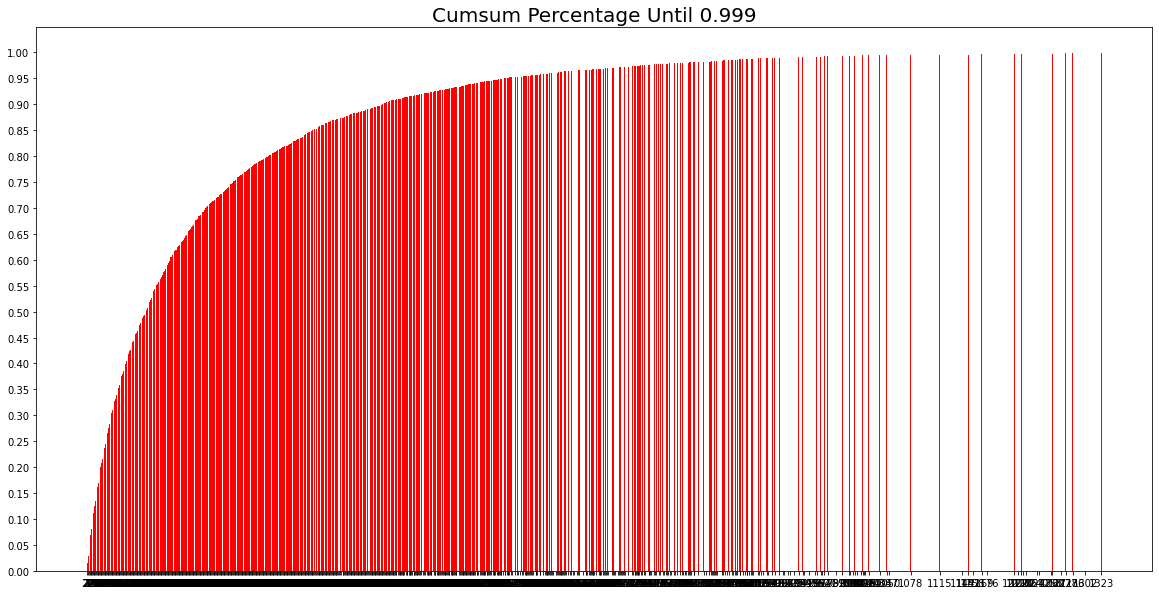

In [209]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

**Rating**
- Rating 정보 확인 및 변경

- Rating은 최고 5점으로 시청한 영화가 맘에 들었는지 여부를 판단합니다.
- Rating의 정보로 비슷한 영화를 더 고르게 할 수도 있습니다.
- Rating이 낮은 데이터는 삭제를 합니다.

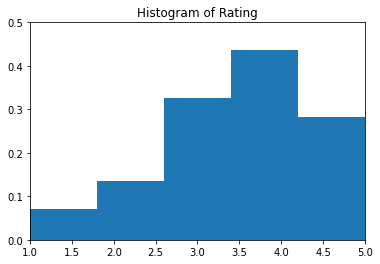

In [210]:
plt.hist(data['Rating'], density=True,bins=5)
plt.title('Histogram of Rating')
plt.axis([1, 5, 0, 0.5])
plt.show()

- 평점 1점과 2점 데이터의 분포가 적어 삭제하도록 합니다.

In [211]:
change_Rating = data[data['Rating']>=3]
print(len(change_Rating))

836478


In [212]:
data = data[data['Rating']>=3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- Rating기준으로 정리하여 1000209개의 데이터에서 836478로 줄어든 것을 확인 할 수 있습니다.

**Session Time**
- 데이터의 시간 정보 확인 및 변경

In [213]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


- Time을 확인해보면 978300019으로 확인하기 어렵게 기재되어 있습니다.
- 편리한 이용을 위해서 Time의 내용을 fromtimestamp()를 이용해 변경합니다.

In [214]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [215]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


- 데이터를 확인해봤을 때 2000년 4월부터 2003년 2월까지의 데이터가 있는 것을 확인할 수 있습니다.

**Data Cleansing**


In [216]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [217]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성

- 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. 
- Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
- 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [218]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [219]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [220]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [221]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 818736
	 Sessions: 6036
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9771
	 Sessions: 390
	 Items: 2348
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7282
	 Sessions: 333
	 Items: 2049
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



- Events: 데이터 갯수
- Sessions: UserId의 고유값
- Items: ItemId의 고유값
- First Time : 최소시간
- Last Time : 최대시간

In [222]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [223]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

**SessionDataset**
- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [224]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [225]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [226]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 818341, 818460, 818736], dtype=int32)

In [227]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

In [228]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [229]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [230]:
iter_ex = iter(tr_data_loader)

In [231]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

In [232]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [233]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [234]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [235]:
model = create_model(args)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_20 (Dropout)         (128, 50)                 0         
_________________________________________________________________
dense_17 (Dense)             (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습

In [236]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [133]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.52] 

	 - Recall@20 epoch 1: 0.094899
	 - MRR@20    epoch 1: 0.022090



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.93]

	 - Recall@20 epoch 2: 0.119256
	 - MRR@20    epoch 2: 0.031675



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.22it/s]

	 - Recall@20 epoch 3: 0.123851
	 - MRR@20    epoch 3: 0.034440



## Step 5. 모델 테스트

In [134]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:16<00:27,  1.22it/s]

	 - Recall@20: 0.135547
	 - MRR@20: 0.037769



---

## Step 6. 모델 개선

### 1. 학습률 변경

**1-1. lr=0.01 변경**

In [142]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.1] 

	 - Recall@20 epoch 1: 0.132812
	 - MRR@20    epoch 1: 0.037225



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.93] 

	 - Recall@20 epoch 2: 0.132812
	 - MRR@20    epoch 2: 0.039370



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.23it/s]

	 - Recall@20 epoch 3: 0.133961
	 - MRR@20    epoch 3: 0.039596



In [143]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:16<00:27,  1.23it/s]

	 - Recall@20: 0.140625
	 - MRR@20: 0.042995



- cs231n에서 하이퍼파라미터 조정할 때 학습률 먼저 확인해본다길래 건들여봤는데 엄청나게 상향된 것 같지 않다.
- 정확도도 그렇고 매트릭스도 그렇고 수치가 안돌리는것만 못한 수치가 나왔다.
- 배치사이즈 이것저것 시도해봤는데 너무 크면 안돌아가고 작으면 텐서가 맞지 않는다고 나온다.
- 그래도 긍정적으로 생각해보면 위에 시도한 것보다 약간 나아졌다.

**1-2. lr=0.1 변경**

In [144]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.09] 

	 - Recall@20 epoch 1: 0.137178
	 - MRR@20    epoch 1: 0.041152



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.15]

	 - Recall@20 epoch 2: 0.135340
	 - MRR@20    epoch 2: 0.040843



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.24it/s]

	 - Recall@20 epoch 3: 0.136719
	 - MRR@20    epoch 3: 0.040717



In [145]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:15<00:27,  1.26it/s]

	 - Recall@20: 0.149219
	 - MRR@20: 0.044284



- 학습률 0.001, 0.01, 0.1을 비교해봤을 때 0.1의 수치가 가장 좋게나왔다.

### 2. epochs 변경
**2-1. epochs=10 변경**

In [146]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=10, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.04]

	 - Recall@20 epoch 1: 0.134651
	 - MRR@20    epoch 1: 0.040699



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.01]

	 - Recall@20 epoch 2: 0.136259
	 - MRR@20    epoch 2: 0.040833



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0469, train_loss=4.99] 

	 - Recall@20 epoch 3: 0.135340
	 - MRR@20    epoch 3: 0.040205



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.125, train_loss=5.04]  

	 - Recall@20 epoch 4: 0.135570
	 - MRR@20    epoch 4: 0.040029



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.02]

	 - Recall@20 epoch 5: 0.135340
	 - MRR@20    epoch 5: 0.040123



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.89]

	 - Recall@20 epoch 6: 0.137178
	 - MRR@20    epoch 6: 0.040629



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5]    

	 - Recall@20 epoch 7: 0.136949
	 - MRR@20    epoch 7: 0.040250



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.92]

	 - Recall@20 epoch 8: 0.136489
	 - MRR@20    epoch 8: 0.040213



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.117, train_loss=4.81]  

	 - Recall@20 epoch 9: 0.137868
	 - MRR@20    epoch 9: 0.040204



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.23it/s]

	 - Recall@20 epoch 10: 0.139017
	 - MRR@20    epoch 10: 0.040457



In [147]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:16<00:27,  1.24it/s]

	 - Recall@20: 0.150000
	 - MRR@20: 0.042168



- 에폭을 늘린다고 성능이 엄청 향상되지 않았다.
- 다른 수정방향이 필요하다.

### 3. drop_rate 변경

**3-1. drop_rate=0.5**

In [148]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.5, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.94] 

	 - Recall@20 epoch 1: 0.137178
	 - MRR@20    epoch 1: 0.040556



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.77]  

	 - Recall@20 epoch 2: 0.137178
	 - MRR@20    epoch 2: 0.040377



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.23it/s]

	 - Recall@20 epoch 3: 0.137638
	 - MRR@20    epoch 3: 0.040412



In [149]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:16<00:27,  1.25it/s]

	 - Recall@20: 0.147266
	 - MRR@20: 0.042505



**3-2. drop_rate=0.9**

In [151]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.9, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.95]

	 - Recall@20 epoch 1: 0.137178
	 - MRR@20    epoch 1: 0.040737



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.117, train_loss=4.78]  

	 - Recall@20 epoch 2: 0.137638
	 - MRR@20    epoch 2: 0.040358



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.23it/s]

	 - Recall@20 epoch 3: 0.136949
	 - MRR@20    epoch 3: 0.040996



In [153]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:16<00:27,  1.23it/s]

	 - Recall@20: 0.147266
	 - MRR@20: 0.043459



**3-3. drop_rate=0**

In [154]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0, lr=0.1, epochs=3, k=20)
train_model(model, args)

Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.133, train_loss=4.71] 

	 - Recall@20 epoch 1: 0.136719
	 - MRR@20    epoch 1: 0.040596



Train:   0%|          | 0/6349 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.77] 

	 - Recall@20 epoch 2: 0.136489
	 - MRR@20    epoch 2: 0.040496



Evaluation:  47%|████▋     | 34/73 [00:27<00:31,  1.23it/s]

	 - Recall@20 epoch 3: 0.138327
	 - MRR@20    epoch 3: 0.041650



In [155]:
test_model(model, args, test)

Evaluation:  37%|███▋      | 20/54 [00:16<00:27,  1.24it/s]

	 - Recall@20: 0.148438
	 - MRR@20: 0.042543



- 에폭이 낮아서 그런지 드롭아웃 여부가 크게 기여하지 않는 것 같다.
- 조금이라도 개선이 되면 좋겠는데 이해하지 못하고 코드만 작성한 것 같다.

---

## 루브릭 관련 고려한 점

**1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.**

- 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

**2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.**

- 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.

**3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.**

- 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

## 회고

1️⃣ 잘한 점:

- 히스토그램으로 data([Rating])을 확인해봤다.


2️⃣ 어려웠던 점:

- 모델 훈련시키는데 인덱스가 축방향을 벗어났다고 계속 뜬다.
- split_by_date() 부분을 수정했으나 여전히 같은 오류 반복으로 해결하는데 어려웠다. 
- 배치사이즈 조절을 해보란 조언을 듣고 수정하니 돌아갔다.
- 배치사이즈가 크면 인덱스가 축범위를 벗어났다는 에러가 뜬다.
- 작으면 텐서 사이즈가 안맞는다고 뜬다.
- 모델이 돌아가도록 수정을 했으나 왜 오류가 나는지 이해를 못한 점이 아쉽다.


- Session-Based Recommendation 개념을 이해하는게 어렵다.
- 그중에서도 이론적인 부분을 실제 사용할 코드로 옮긴다는 게 어려운 것 같다.
- 어느부분을 수정을 해야하는지, 어쩨서 실행이 안되는지 에러코드만으로는 이해하고 이를 수정하기 어려웠다.

- 왜 트레이닝과 테스트 모두 일정 수치에서 멈출까? 배치 사이즈 때문인가?

3️⃣ 느낀 점:


- 잘하고 싶다.